In [1]:
import csv
import datetime
import math
import matplotlib.pyplot as plt

from collections import defaultdict

KEY_COUNTRY = 1
KEY_DATES_START = 4

# Returns a proper `datetime` from `date_str` in a format like
# '1/22/20', which represents January 22nd, 2020.
def make_date(date_str):
    parts = date_str.split('/')
    assert(len(parts) == 3)
    return datetime.date(2000 + int(parts[2]), int(parts[0]), int(parts[1]))

class Country(object):
    def __init__(self, name, population, series_data):
        self.name = name
        self.population = population
        self.timeseries = series_data

    def get(self, series, perm=False):
        factor = 1000.0/self.population if perm else 1.0
        return [v*factor for v in self.timeseries[series]]
            

def read_one_data_series(series):
    country_data = dict()
    with open(f'data/{series}.csv') as fin:
        reader = csv.reader(fin, delimiter=',', quotechar='"')
        header = next(reader)
        dates = [make_date(date_str) for date_str in header[KEY_DATES_START:]]
        for line in reader:
            name = line[KEY_COUNTRY]
            vals = [int(v) for v in line[KEY_DATES_START:]]
            assert(len(vals) == len(dates))
            if name not in country_data:
                country_data[name] = vals
            else:
                # Another province/state for the same country.
                # We just sum this up.
                cur = country_data[name]
                assert(len(cur) == len(vals))
                for i in range(len(cur)):
                    cur[i] += vals[i]
    return dates, country_data

class DB(object):
    def __init__(self):
        self.dates = None
        # {country name -> {series name -> timeseries numbers}}
        per_country = defaultdict(dict)
        for series in ['confirmed', 'recovered', 'dead']:
            dates, country_data = read_one_data_series(series)
            if self.dates is None:
                self.dates = dates
            else:
                # We're assuming all the dates are present in all the datasets.
                assert(self.dates == dates)
            if len(per_country) > 0:
                assert(set(per_country.keys()) == set(country_data.keys()))
            for country, vals in country_data.items():
                per_country[country][series] = vals

        # {country name -> population}
        populations = dict()
        with open('data/country_population.txt') as fin:
            for line in fin:
                parts = line.split(' ')
                populations[' '.join(parts[:-1])] = int(parts[-1])
        # {country name -> Country}
        self.countries = dict()
        for name, series_data in per_country.items():
            try:
                pop = populations[name]
            except:
                print('Missing population for', name)
                pop = 1
            self.countries[name] = Country(name, pop, series_data)

    def country(self, country_name):
        return self.countries[country_name]

def log(lst):
    return [None if x == 0 else math.log10(x) for x in lst]

db = DB()
countries_to_plot = ['Croatia', 'Switzerland', 'Italy', 'US', 'United Kingdom']

Missing population for Bahamas
Missing population for Diamond Princess
Missing population for Gambia
Missing population for West Bank and Gaza
Missing population for Saint Kitts and Nevis
Missing population for Kosovo
Missing population for Burma


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

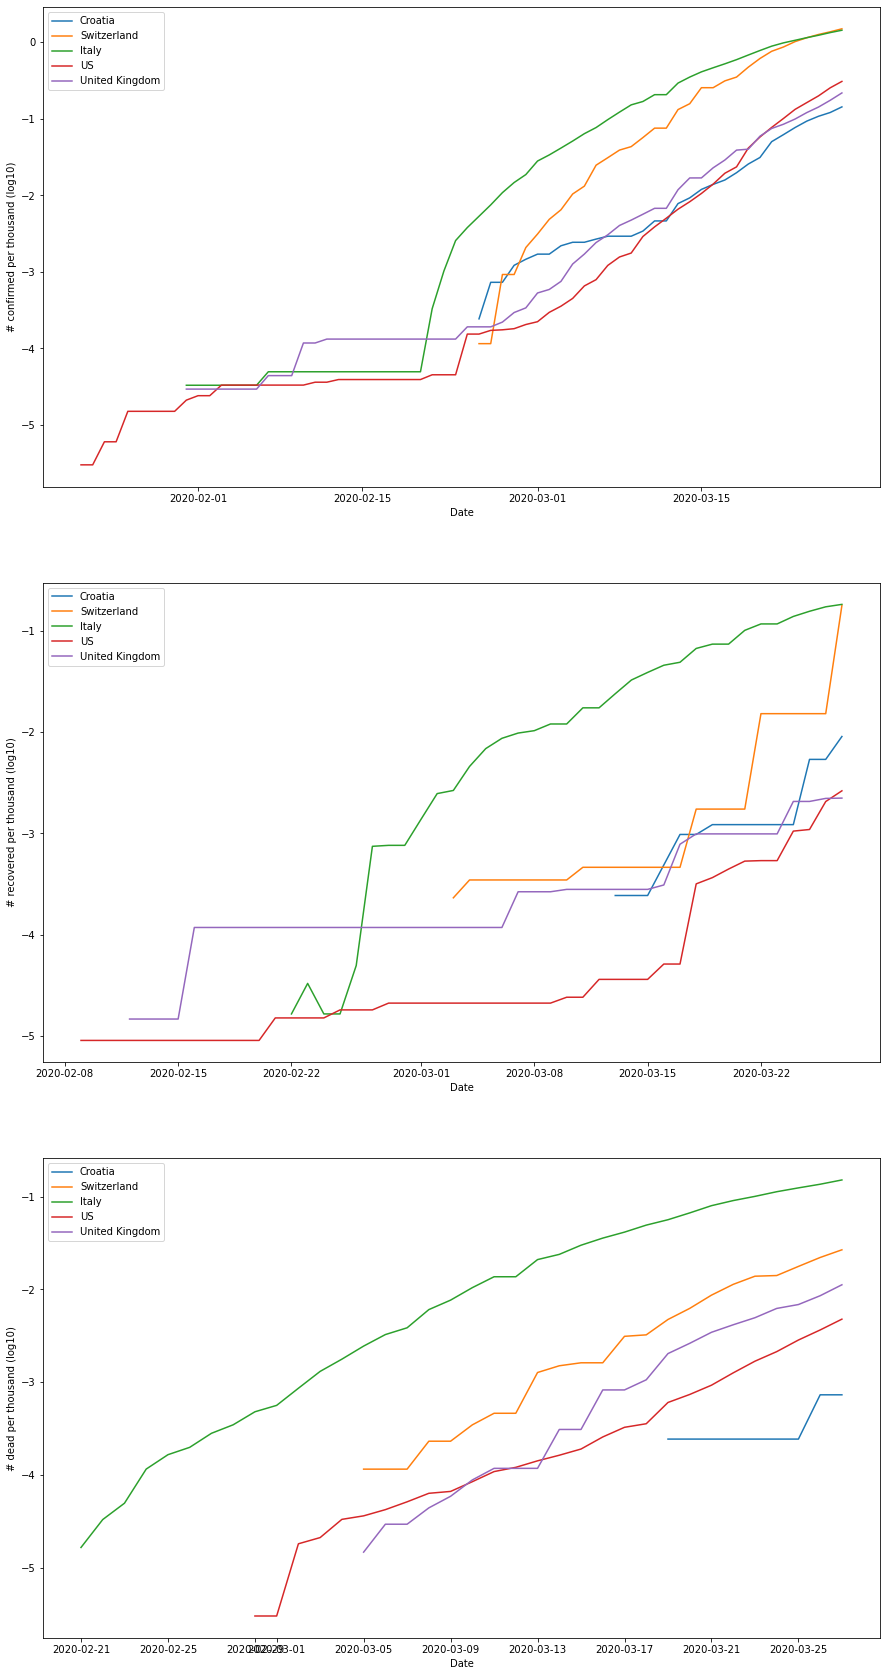

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(15, 30))

for i, series in enumerate(['confirmed', 'recovered', 'dead']):
    ax = axes[i];
    for cname in countries_to_plot:
        ax.plot(db.dates, log(db.country(cname).get(series, perm=True)), label=cname)
    ax.set_ylabel('# {} per thousand (log10)'.format(series))
    ax.set_xlabel('Date')
    ax.legend()

plt.show()

Croatia start date 2020-02-29
Best fit exponential: 2.5074415060754434 * exp10(0.085429113641236 * t)
Best fit sigmoid: 938.8221965828807 / (1.0 + exp10(-0.13091904619223427 * (t - 26.404087610061925)))


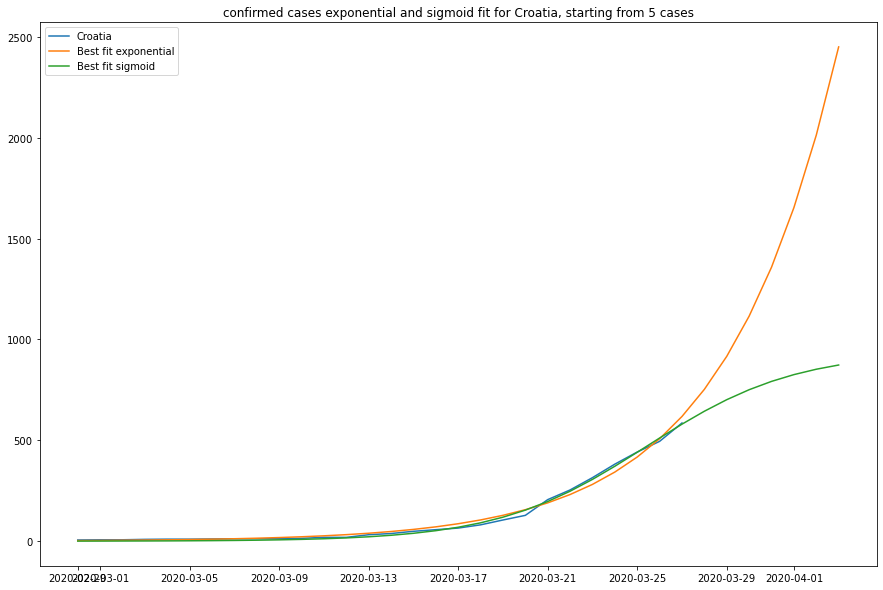

Switzerland start date 2020-02-27
Best fit exponential: 137.03423862200663 * exp10(0.06726089746770132 * t)
Best fit sigmoid: 16927.505305069953 / (1.0 + exp10(-0.12093708572924136 * (t - 25.84334803850515)))


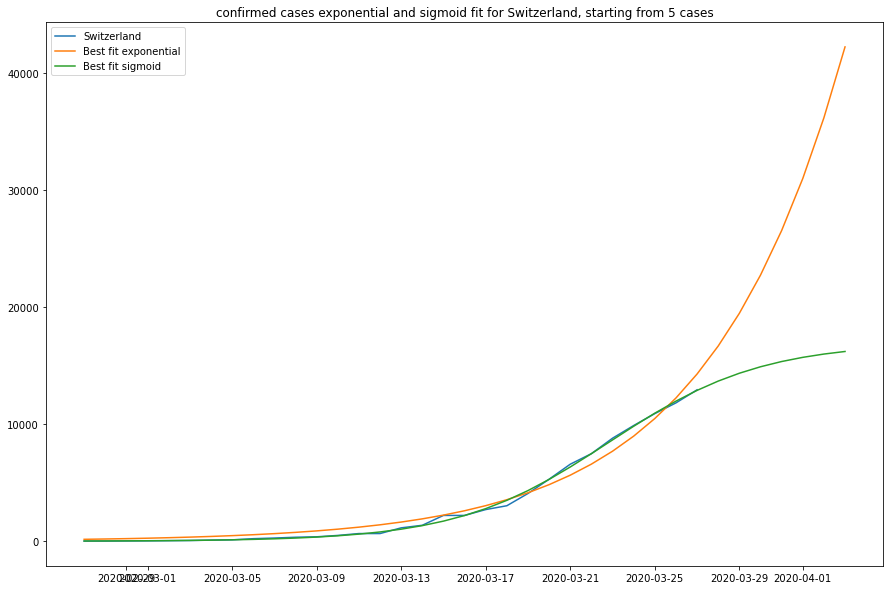

Italy start date 2020-02-21
Best fit exponential: 1459.2053051599448 * exp10(0.050335515188268426 * t)
Best fit sigmoid: 119198.94239448702 / (1.0 + exp10(-0.084332913714128 * (t - 31.201882175333903)))


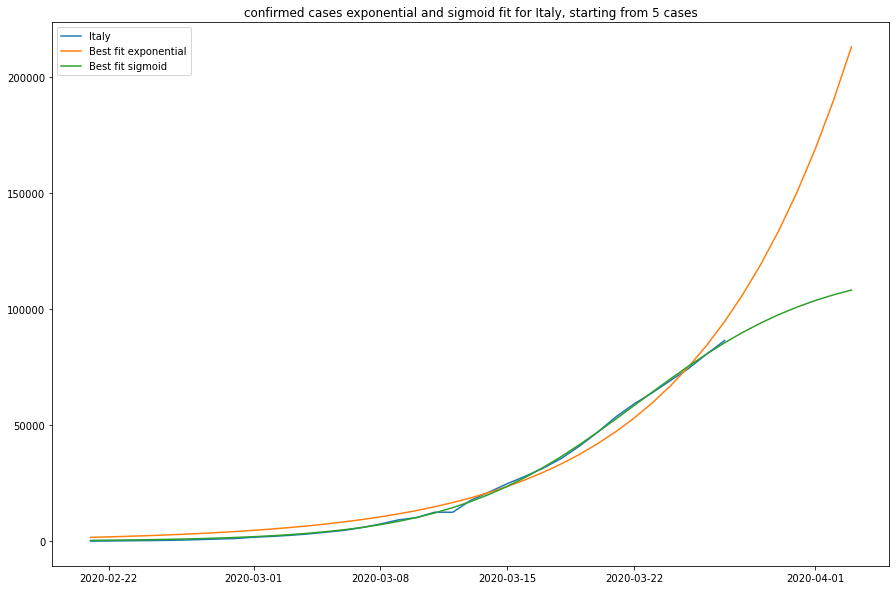

US start date 2020-01-31
Best fit exponential: 0.1098432989277074 * exp10(0.10493288164540213 * t)
Best fit sigmoid: 218174.56421013107 / (1.0 + exp10(-0.1388996279000075 * (t - 57.47011185926481)))


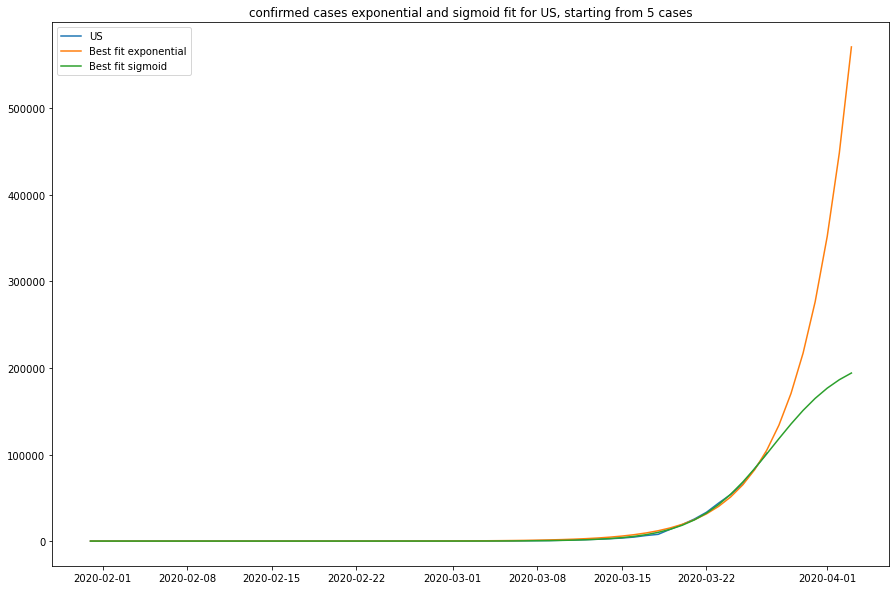

United Kingdom start date 2020-02-10
Best fit exponential: 1.4335180209113272 * exp10(0.0853040971757511 * t)
Best fit sigmoid: 101046.60161874753 / (1.0 + exp10(-0.09165725993374611 * (t - 55.475738698367856)))


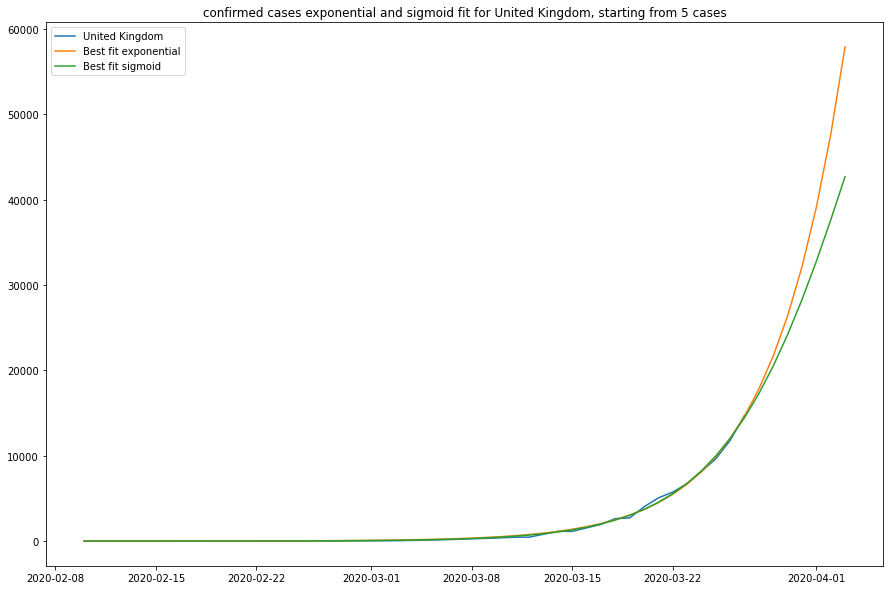

In [9]:
import numpy as np

from scipy.optimize import curve_fit
from scipy.special import exp10

def get_start_and_align(country_name, series, start_val, perm):
    data = db.country(country_name).get(series, perm=perm)
    for i, (t, val) in enumerate(zip(db.dates, data)):
        if val > start_val:
            return db.dates[i:], data[i:]

def exponential(t, a, b):
    return a * exp10(b * t)

def sigmoid(t, a, b, c):
    return a / (1.0 + exp10(-b * (t - c)))

DAYS_EXTEND = 7

def country_exp_vs_sigmoid(country, series):
    dates, data = get_start_and_align(country, series, 5, perm=False)
    print('{} start date {}'.format(country, dates[0]))
    (aexp, bexp), _ = curve_fit(exponential, np.arange(1, len(data) + 1), data, p0=(1, 0.3))
    print('Best fit exponential: {} * exp10({} * t)'.format(aexp, bexp))
    (asig, bsig, csig), _ = curve_fit(sigmoid, np.arange(1, len(data) + 1), data, p0=(data[-1], 0.2, 21))
    print('Best fit sigmoid: {} / (1.0 + exp10(-{} * (t - {})))'.format(asig, bsig, csig))

    ts_extended = np.arange(1, len(data) + 1 + DAYS_EXTEND)
    dates_extended = dates[::] + [dates[-1] + datetime.timedelta(days=d) for d in range(1, DAYS_EXTEND + 1)]
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(dates, data, label=country)
    ax.plot(dates_extended, exponential(ts_extended, aexp, bexp), label='Best fit exponential')
    ax.plot(dates_extended, sigmoid(ts_extended, asig, bsig, csig), label='Best fit sigmoid')
    ax.set_title('{} cases exponential and sigmoid fit for {}, starting from 5 cases'.format(series, country))
    ax.legend()
    plt.show()

for country in countries_to_plot:
    country_exp_vs_sigmoid(country, 'confirmed')

Korea, South start date 2020-01-31
Best fit exponential: 731.9110306570417 * exp10(0.021272123040139188 * t)
Best fit sigmoid: 8715.662402538816 / (1.0 + exp10(-0.12672902314602813 * (t - 32.27487798981062)))


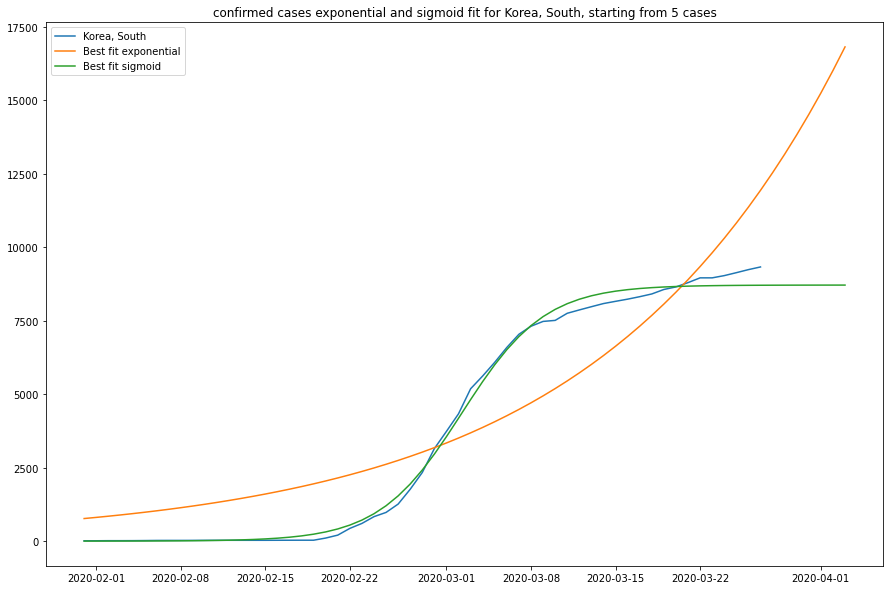

Japan start date 2020-01-28
Best fit exponential: 31.71946809779371 * exp10(0.02804262585958433 * t)
Best fit sigmoid: 2120.4889610616865 / (1.0 + exp10(-0.043012991091067515 * (t - 53.62684037421464)))


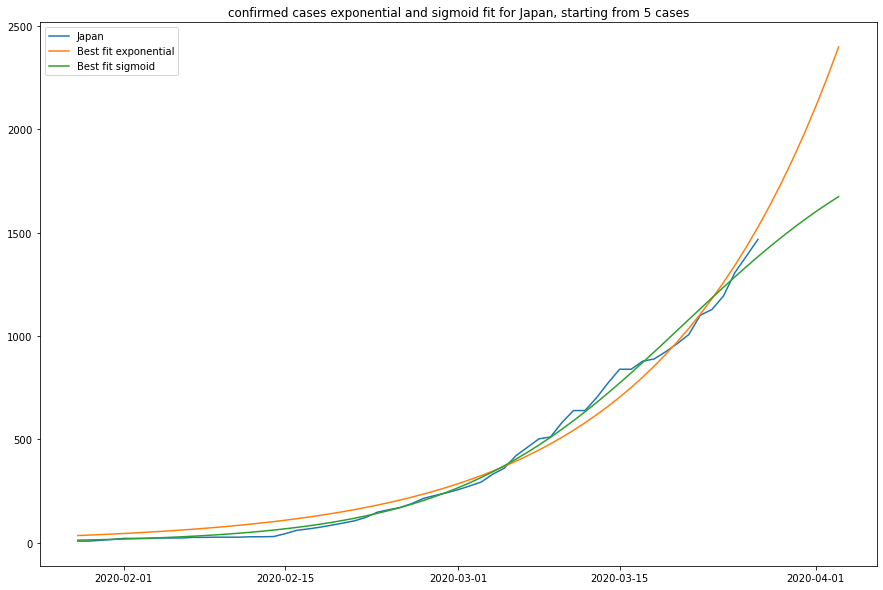

China start date 2020-01-22
Best fit exponential: 29371.73285494386 * exp10(0.008286203232080304 * t)
Best fit sigmoid: 81093.8441027599 / (1.0 + exp10(-0.09601849796775802 * (t - 18.784898930025516)))


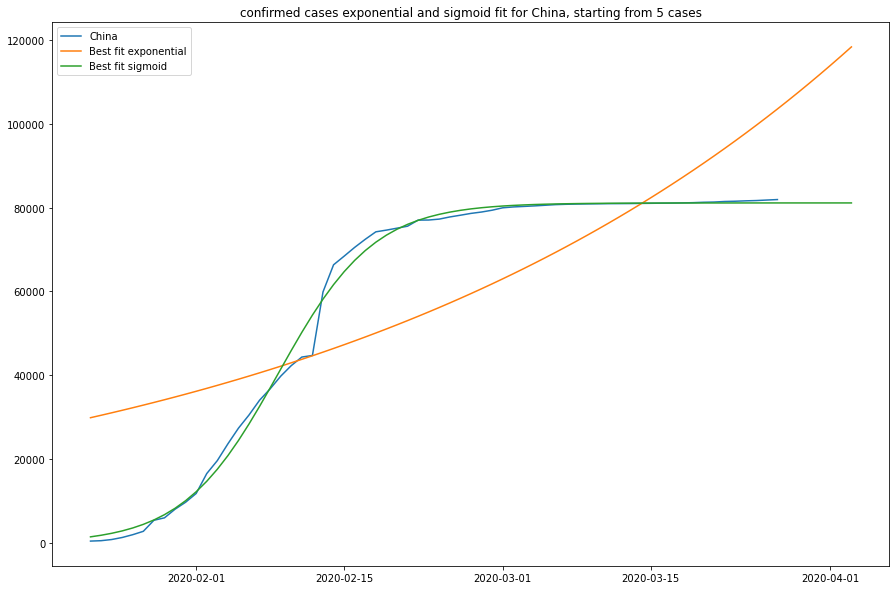

In [10]:
recovering_countries = ['Korea, South', 'Japan', 'China']
for country in recovering_countries:
    country_exp_vs_sigmoid(country, 'confirmed')

Best fit exponential Croatia: 0.00027834747930899204 * exp10(0.08541538941397943 * t)
Best fit exponential Switzerland: 0.011583201384342387 * exp10(0.06730234510719936 * t)
Best fit exponential Italy: 0.024134347963380653 * exp10(0.05033550185589151 * t)
Best fit exponential US: 0.00010947973065002967 * exp10(0.10493280362851594 * t)
Best fit exponential United Kingdom: 2.1116596163386678e-05 * exp10(0.08530407383426533 * t)


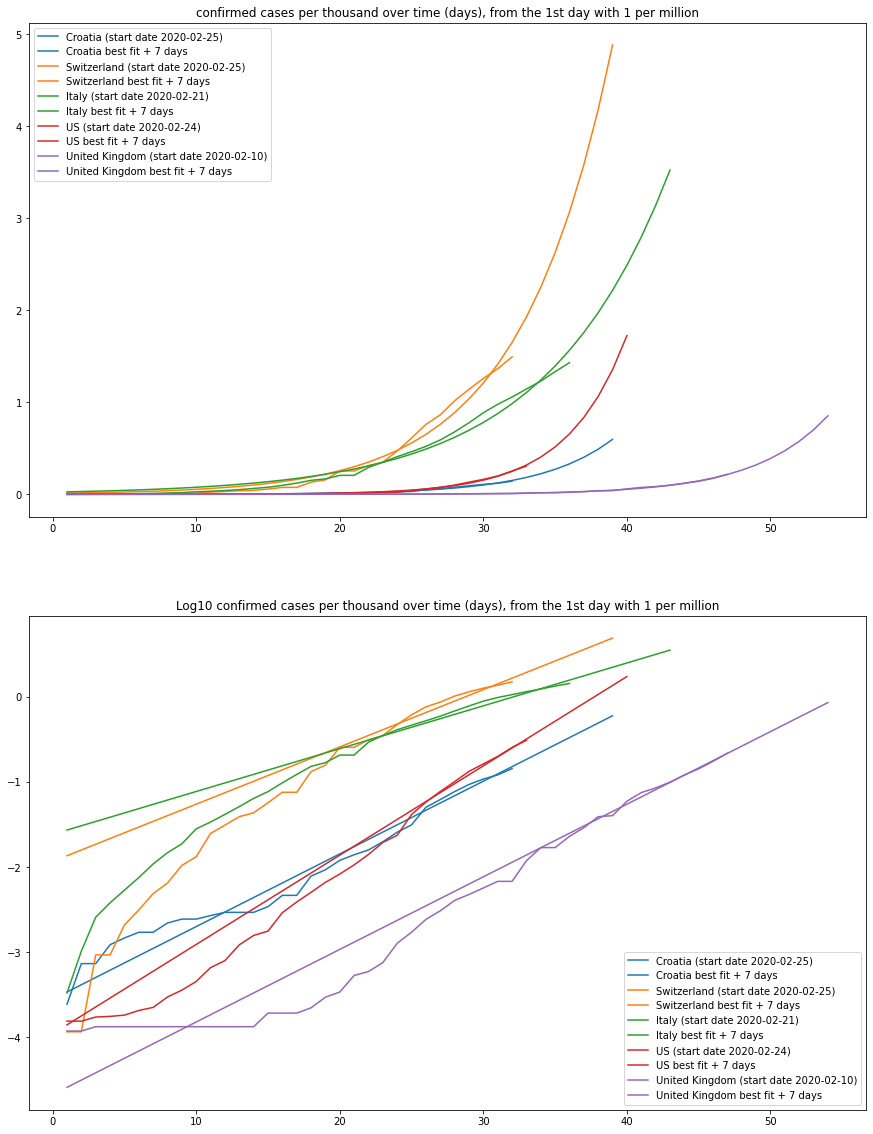

In [12]:
def identity(lst):
    return lst

def compare_countries(series, countries, start_value=(0.0001, '1 per million')):
    fig, axes = plt.subplots(2, 1, figsize=(15, 20))

    for cidx, country in enumerate(countries):
        # Start each country when they had 1 case per million.
        dates, data = get_start_and_align(country, series, start_value[0], perm=True)
        data_label = '{} (start date {})'.format(country, dates[0])
        fit_label = '{} best fit + {} days'.format(country, DAYS_EXTEND)
        xs = np.arange(1, len(data) + 1)
        (aexp, bexp), _ = curve_fit(exponential, xs, data, p0=(1, 0.3))
        print('Best fit exponential {}: {} * exp10({} * t)'.format(country, aexp, bexp))
    
        xs_extended = np.arange(1, len(xs) + 1 + DAYS_EXTEND)
        color = 'C{}'.format(cidx)
    
        for fnidx, fn in enumerate([identity, log]):
            ax = axes[fnidx]
            ax.plot(xs, fn(data), color, label=data_label)
            ax.plot(xs_extended, fn(exponential(xs_extended, aexp, bexp)), color, label=fit_label)

    axes[0].legend()
    axes[0].set_title('{} cases per thousand over time (days), from the 1st day with {}'.format(series, start_value[1]))
    axes[1].legend()
    axes[1].set_title('Log10 {} cases per thousand over time (days), from the 1st day with {}'.format(series, start_value[1]))
    plt.show()
    
compare_countries('confirmed', countries_to_plot)

Best fit exponential Croatia: 9.808259162856465e-05 * exp10(0.09505150029037751 * t)
Best fit exponential Switzerland: 0.00023033009766307313 * exp10(0.09012704688088262 * t)
Best fit exponential Italy: 0.0011163307500547362 * exp10(0.06005771303276528 * t)
Best fit exponential US: 2.7948414976808785e-06 * exp10(0.11546692986032411 * t)
Best fit exponential United Kingdom: 6.973921454650683e-05 * exp10(0.09585559983810413 * t)


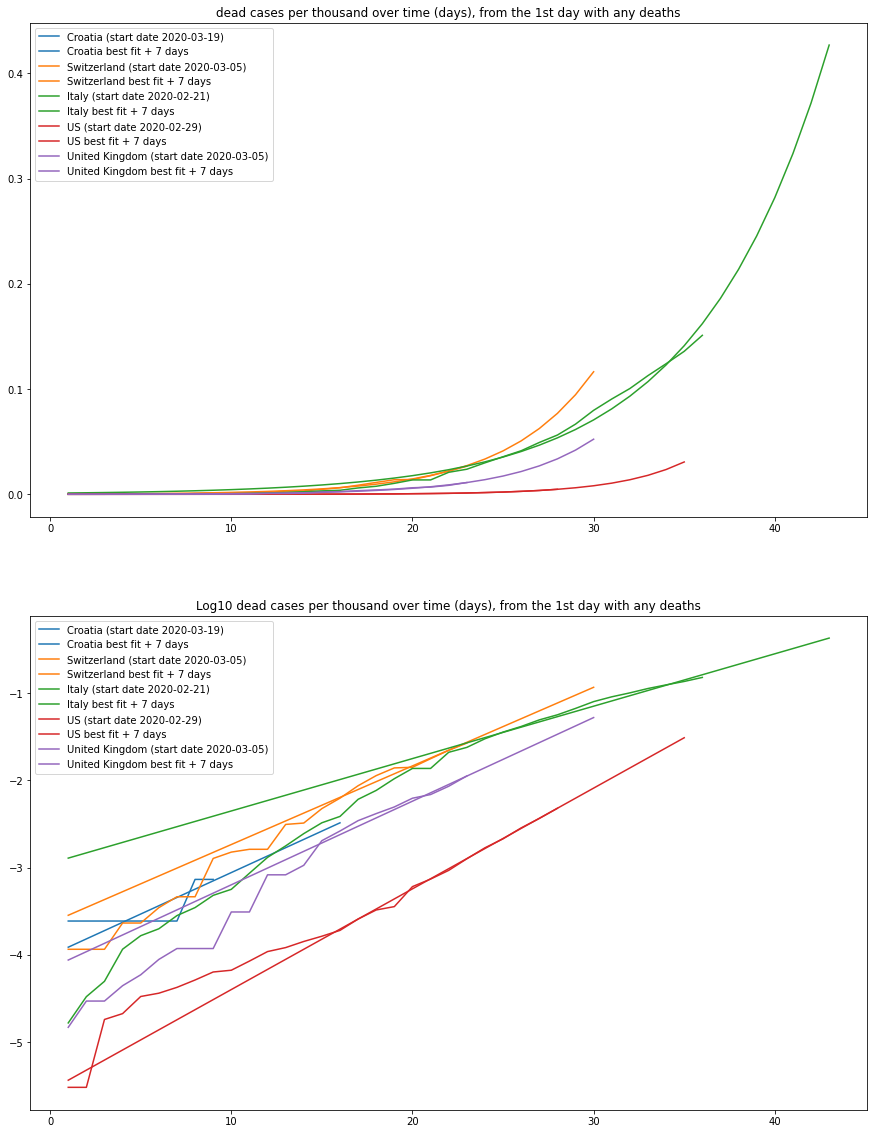

In [13]:
# Not reliable for many of these countries as they are still in early stages!
compare_countries('dead', countries_to_plot, start_value=(0, 'any deaths'))